 #Traffic Analysis of Chicago using Twitter 
 
 Project by:
 
 Ishan Bilolikar (A20320338)
 
 Latika Singh (A20336453)

In [527]:
from collections import Counter
import matplotlib.pyplot as plt
import glob
import hashlib
import io
import math
import os
import sys
import re
import csv
import datetime
import jsonpickle
import random
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from TwitterAPI import TwitterAPI
%matplotlib inline

In [4]:
#Download data from twitter for every region using geocode
import tweepy
#Reference http://www.karambelkar.info/2015/01/how-to-use-twitters-search-rest-api-most-effectively./
# Replace the API_KEY and API_SECRET with your application's key and secret.
auth = tweepy.AppAuthHandler('API_KEY', 'API_SECRET')
 
api = tweepy.API(auth, wait_on_rate_limit=True,wait_on_rate_limit_notify=True)
 
if (not api):
    print ("Can't Authenticate")
    sys.exit(-1)
    

searchQuery = 'chicago traffic'  # this is what we're searching for
maxTweets = 10000000 # Some arbitrary large number
tweetsPerQry = 100  # this is the max the API permits
geocode = '41.866129,-87.595378,1mi' #input geocode. Longitude,latitude,radius
fName = 'region7.txt' # We'll store the tweets in a text file.


# If results from a specific ID onwards are reqd, set since_id to that ID.
# else default to no lower limit, go as far back as API allows
sinceId = None

# If results only below a specific ID are, set max_id to that ID.
# else default to no upper limit, start from the most recent tweet matching the search query.
max_id = -1L

tweetCount = 0
print("Downloading max {0} tweets".format(maxTweets))
with open('data'+os.sep+fName, 'a') as f:
    while tweetCount < maxTweets:
        try:
            if (max_id <= 0):
                if (not sinceId):
                    new_tweets = api.search(q=searchQuery,geocode = geocode, count=tweetsPerQry)
                else:
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                            since_id=sinceId)
            else:
                if (not sinceId):
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                            max_id=str(max_id - 1))
                else:
                    new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                            max_id=str(max_id - 1),
                                            since_id=sinceId)
            if not new_tweets:
                print("No more tweets found")
                break
            for tweet in new_tweets:
                f.write(jsonpickle.encode(tweet._json, unpicklable=False) +
                        '\n')
            tweetCount += len(new_tweets)
            print("Downloaded {0} tweets".format(tweetCount))
            max_id = new_tweets[-1].id
        except tweepy.TweepError as e:
            # Just exit if any error
            print("some error : " + str(e))
            break

print ("Downloaded {0} tweets, Saved to {1}".format(tweetCount, fName))

No more tweets found
Downloaded 0 tweets, Saved to region7.txt


In [416]:
def get_data():
    path = 'data'
    filenames = []
    for filename in os.listdir(path):
        if ".txt" in filename:
            filenames.append(filename)
    
    return sorted(filenames)

filenames = get_data()
print '%d region tweet files found' % len(filenames)
print filenames

25 region tweet files found
['region1.txt', 'region10.txt', 'region11.txt', 'region12.txt', 'region14.txt', 'region15.txt', 'region16.txt', 'region17.txt', 'region2.txt', 'region20.txt', 'region21.txt', 'region22.txt', 'region24.txt', 'region25.txt', 'region26.txt', 'region27.txt', 'region28.txt', 'region29.txt', 'region3.txt', 'region4.txt', 'region5.txt', 'region6.txt', 'region7.txt', 'region8.txt', 'region9.txt']


In [419]:
labeled_files = ['region1.txt','region8.txt','region22.txt']
unlabeled_files = [filename for filename in filenames if filename not in labeled_files]

In [316]:
#get tweets from a file
def get_file_data(filename):
    '''
    param....
        filename.....filename of the file
    return....list of text of all tweets in the file        
    '''
    tweets = []
    f = open('data'+os.sep+filename, 'r')
    for line in f:
        t = jsonpickle.decode(line)
        tweets.append(t['text'])
        
    f.close()
    
    return tweets

region1_tweets = get_file_data('region1.txt')
print '%d tweets found in region1' % len(region1_tweets)
print 'First tweet text:'
print region1_tweets[0]

978 tweets found in region1
First tweet text:
Closed in #NorthSide on Lawrence Ave Both EB/WB between N Sheridan Rd and Broadway St #traffic #Chicago https://t.co/GCesNZGx1X


In [317]:
def get_true_labels(filename):
    '''
    tweets are labeled manually in the file with the key 'label'
    param...
        filename...filename
    return...list of true labels of all the manually labeled tweets
    '''
    true_labels = []
    f = open('data'+os.sep+filename, 'r')
    for line in f:
        t = jsonpickle.decode(line)
        true_labels.append(t['label']) 
    f.close()
    return np.array(true_labels)

y = get_true_labels('region1.txt')
print len(y),' true labels'
print (y)

978  true labels
[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 1 0 0 0 1 1 1 0
 1 0 0 1 0 0 0 0 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1
 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0
 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0

In [318]:
def tokenize(text,options):
    """ Split a tweet into tokens."""
    '''
    param....
        text....text which needs to be tokenized
        options....tokenizer is a list of options requied to tokenize the text 
                    eg. ['lowercase','keep_punctuation',  'collapse_mentions'] will consider these as true
    return....list of tokens
    '''
    if not text:
        return []
    keep_punctuations = False
    for option in options:
        if option == 'lowercase':
            text = text.lower()
        tokens = []
        if option == 'collapse_urls':
            text = re.sub('http\S+', 'THIS_IS_A_URL', text)
        if option == 'collapse_mentions': 
            text = re.sub('@\S+', 'THIS_IS_A_MENTION', text)
        if option == 'collapse_hashtags':
            text = re.sub('#\S+', 'THIS_IS_A_HashTag', text)
        if option == 'keep_punctuation':
            keep_punctuations = True
            
    if keep_punctuations:
        tokens = text.split()
    else:
        tokens = re.sub('\W+', ' ', text.lower()).split()
    return tokens

tokenize(region1_tweets[0],['lowercase','keep_punctuation', 'collapse_mentions','collapse_urls'])


[u'closed',
 u'in',
 u'#northside',
 u'on',
 u'lawrence',
 u'ave',
 u'both',
 u'eb/wb',
 u'between',
 u'n',
 u'sheridan',
 u'rd',
 u'and',
 u'broadway',
 u'st',
 u'#traffic',
 u'#chicago',
 u'THIS_IS_A_URL']

In [319]:
def do_vectorize(all_tweets, tokenizer_fn=tokenize,options=[], min_df=2,
                  binary=True):
    """
    Convert a list of filenames into a sparse csr_matrix, where
    each row is a file and each column represents a unique word.
    Use sklearn's CountVectorizer: http://goo.gl/eJ2PJ5
    Params:
        all_tweets......list of 'text' of all tweets
        tokenizer_fn....the function used to tokenize each document
        options.........list of options for the tokenizer. 5 options available
                ['lowercase', 'keep_punctuation', 'collapse_hashtags', 'collapse_urls', 'collapse_mentions']
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
    Return:
        A tuple (X, vec), where X is the csr_matrix of feature vectors,
        and vec is the CountVectorizer object.
    """
    vect = CountVectorizer(input='content',tokenizer= lambda text: tokenizer_fn(text,options), 
                           min_df=min_df,binary=binary)
    Matrix = vect.fit_transform(all_tweets)
    return Matrix, vect
    ###
    
matrix, vec = do_vectorize(region1_tweets)
print ('matrix represents %d documents with %d features' % (matrix.shape[0], matrix.shape[1]))
print('first doc has terms:\n%s' % (str(sorted(matrix[0].nonzero()[1]))))
    

matrix represents 978 documents with 1029 features
first doc has terms:
[109, 132, 158, 176, 182, 218, 239, 241, 317, 392, 453, 469, 615, 659, 729, 794, 834, 866, 915, 965]


In [320]:
#Create a LogsticRegression object
def get_clf():
    return LogisticRegression(random_state=42)

In [321]:
def do_cross_validation(X, y, n_folds=5, verbose=False):
    """
    Perform n-fold cross validation, calling get_clf() to train n
    different classifiers. Use sklearn's KFold class: http://goo.gl/wmyFhi
    Be sure not to shuffle the data, otherwise your output will differ.
    Params:
        X.........a csr_matrix of feature vectors
        y.........the true labels of each document
        n_folds...the number of folds of cross-validation to do
        verbose...If true, report the testing accuracy for each fold.
    Return:
        the average testing accuracy across all folds.
    """
    model =  get_clf()
    cv = KFold(len(y), n_folds=n_folds, random_state = model)
    accuracies = []
    for train_ind, test_ind in cv:
        model.fit(X[train_ind], y[train_ind])
        predictions = model.predict(X[test_ind])
        accuracy = accuracy_score(y[test_ind], predictions)
        if verbose is True:
            print 'fold %d accuracy = %.4f'%(len(accuracies) , accuracy)
        accuracies.append(accuracy)
        mean = np.mean(accuracies)
    return mean
    
print('average cross validation accuracy=%.4f' %
      do_cross_validation(matrix, y, verbose=True))

fold 0 accuracy = 0.8520
fold 1 accuracy = 0.9490
fold 2 accuracy = 0.9694
fold 3 accuracy = 0.8462
fold 4 accuracy = 0.8205
average cross validation accuracy=0.8874


In [331]:
def do_expt(tweets, y, tokenizer_fn=tokenize,options = [],
            min_df=2, binary=True, n_folds=5):
    """
    Run one experiment, which consists of vectorizing each file,
    performing cross-validation, and returning the average accuracy.
    You should call do_vectorize and do_cross_validation here.
    Params:
        tweets..........list of 'text' of all tweets
        y...............the true sentiment labels for each file
        tokenizer_fn....the function used to tokenize each document
        options.........list of options for the tokenizer. 5 options available
                ['lowercase', 'keep_punctuation', 'collapse_hashtags', 'collapse_urls', 'collapse_mentions']
        min_df..........remove terms from the vocabulary that don't appear
                        in at least this many documents
        binary..........If true, each documents is represented by a binary
                        vector, where 1 means a term occurs at least once in 
                        the document. If false, the term frequency is used instead.
        n_folds.........The number of cross-validation folds to use.
    Returns:
        the average cross validation testing accuracy.
    """
    matrix, vec = do_vectorize(tweets,tokenizer_fn=tokenizer_fn,options = options,min_df=min_df,binary=binary)
    avg_accuracy = do_cross_validation(matrix, y, n_folds=n_folds)
    return avg_accuracy

In [466]:
print('accuracy using default settings: %.4g' % do_expt(region1_tweets, y))

accuracy using default settings: 0.8874


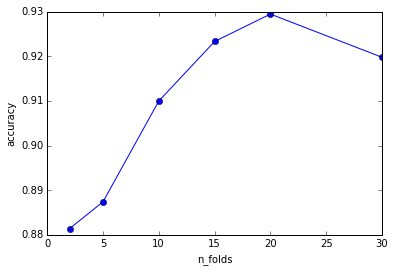

[0.88139059304703471,
 0.88741496598639458,
 0.90998316852514216,
 0.92332556332556359,
 0.92946428571428574,
 0.91979166666666667]

In [515]:
def compare_n_folds(tweets, y):
    """
    Vary the setting of n_folds parameter in the do_expt 
    function to be in [2,5,10,20]. For each setting, call do_expt and 
    store the resulting accuracy. Plot the accuracies for each setting.
    Also return the list of accuracies. Use the default value for all
    other arguments to the do_expt function.
    Params:
        tweets.......list of 'text' of all tweets
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per fold.
    """
    avg = []
    value_list = [2,5,10,15,20,30]
    for v in value_list:
        a = do_expt(tweets,y,n_folds=v)
        avg.append(a)
        
    
    plt.plot(value_list , avg, 'bo-')
    plt.xlabel("n_folds")
    plt.ylabel("accuracy")
    plt.show()
    return avg
    
compare_n_folds(region1_tweets, y)

It is observed that the accuracy decreseases after 20 folds

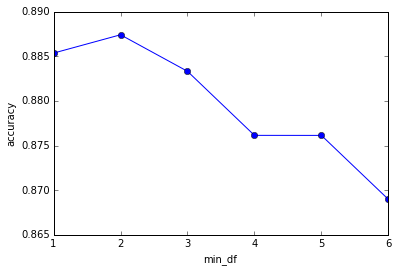

[0.88536368393511256,
 0.88741496598639458,
 0.88332286760858181,
 0.87614861329147042,
 0.87614338042909468,
 0.86897959183673468]

In [526]:
def min_df_expt(tweets, y):
    """
    Vary the setting of min_df parameter in the do_expt 
    function to be ints in the range (1,6) (inclusive). 
    Params:
        tweets.......list of text training file names
        y............true labels for each file (a numpy array)
    Returns:
        a list of average testing accuracies, one per min_df value.
    """
    accuracy_list = []
    min_df_list = [n for n in range(1,7)]
    
    for n in min_df_list:
        accuracy_list.append(do_expt(tweets, y,min_df=n))
    plt.plot(min_df_list,accuracy_list,'bo-')
    plt.xlabel('min_df')
    plt.ylabel('accuracy')
    plt.show()
    return accuracy_list

min_df_expt(region1_tweets, y)

In [525]:
option = ['collapse_hashtags']
print 'Options: ',option
print('accuracy using above options : %.4g' %  do_expt(region22_tweets, y, tokenizer_fn = tokenize,options=option))

Options:  ['collapse_hashtags']
accuracy using above options : 0.8496


**Note:** Accuracy is decreased when hastags are collapsed.

In [524]:
from itertools import product
def show_all_possible_accuracies(tweets,y,tokenizer_fn = tokenize):
    #This method takes all labeled tweets and calculates accuracy 
    #for all possible option in tokenizer function
    '''
    Params....
        tweets......list of text of all tweets
        y...........list true labels of the tweets
    Result...Display accuracy of the training data with all possible option .
    '''
    lowercase_opts = ['lowercase', '']
    keep_punctuation_opts = ['keep_punctuation', '']
    hashtag_opts = ['collapse_hashtags', '']
    url_opts = ['collapse_urls', '']
    mention_opts = ['collapse_mentions', '']
    argnames = ['lowercase', 'keep_punctuation', 'collapse_hashtags', 
                'collapse_urls', 'collapse_mentions']
    option_iter = product(lowercase_opts,
                           keep_punctuation_opts,
                           hashtag_opts, url_opts,
                           mention_opts)
    #acc = []
    for options in option_iter:
        combinations = []
        for name, opt in zip(argnames, options):
            if opt == '':
                t ='False'
            else:
                t = 'True'
            opt_text = name+'='+t
            combinations.append(opt_text)
        print '  '.join('%s' % opttext for opttext in combinations)
        print
        print('Accuracy: %.4g' %  do_expt(tweets, y, tokenizer_fn = tokenize,options=options))
        print '----'*20
        #acc.append(do_expt(tweets, y, tokenizer_fn = tokenizer_fn, options=options))

show_all_possible_accuracies(region1_tweets,y)

lowercase=True  keep_punctuation=True  collapse_hashtags=True  collapse_urls=True  collapse_mentions=True

Accuracy: 0.8598
--------------------------------------------------------------------------------
lowercase=True  keep_punctuation=True  collapse_hashtags=True  collapse_urls=True  collapse_mentions=False

Accuracy: 0.8394
--------------------------------------------------------------------------------
lowercase=True  keep_punctuation=True  collapse_hashtags=True  collapse_urls=False  collapse_mentions=True

Accuracy: 0.8659
--------------------------------------------------------------------------------
lowercase=True  keep_punctuation=True  collapse_hashtags=True  collapse_urls=False  collapse_mentions=False

Accuracy: 0.8639
--------------------------------------------------------------------------------
lowercase=True  keep_punctuation=True  collapse_hashtags=False  collapse_urls=True  collapse_mentions=True

Accuracy: 0.868
----------------------------------------------------

**Top settings that give accuracy above 89%**

**1.**lowercase=True  keep_punctuation=False  collapse_hashtags=False  collapse_urls=True  collapse_mentions=True

Accuracy: 0.8956

**2.**lowercase=True  keep_punctuation=False  collapse_hashtags=False  collapse_urls=False  collapse_mentions=True

Accuracy: 0.8956
    
**3.**lowercase=False  keep_punctuation=False  collapse_hashtags=False  collapse_urls=True  collapse_mentions=True

Accuracy: 0.8956
    
**4.**lowercase=False  keep_punctuation=False  collapse_hashtags=False  collapse_urls=False  collapse_mentions=True

Accuracy: 0.8956

**5.**lowercase=False  keep_punctuation=False  collapse_hashtags=False  collapse_urls=True  collapse_mentions=False

Accuracy: 0.8936
    
**6.**lowercase=True  keep_punctuation=False  collapse_hashtags=False  collapse_urls=True  collapse_mentions=False

Accuracy: 0.8936

**Note that collapse_hastags is False in all top options**

#Test Data

In [517]:
# First, we'll train our final classifier using our best settings.
X, vec = do_vectorize(region1_tweets, tokenizer_fn=tokenize,
                      options=['lowercase', 'collapse_urls', 'collapse_mentions'],
                      binary=True, min_df=2)
clf = get_clf()
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0)

In [355]:
print type(clf.coef_)
print clf.coef_.shape

<type 'numpy.ndarray'>
(1L, 890L)


In [523]:
# Here are the first 10 coefficients.
print(clf.coef_[0][:10])
# The features corresponding to them can be found using the vectorizer's get_feature_names method.
print(vec.get_feature_names()[:10])

[ 0.10640977  0.08158325  0.06718758  0.09164162 -0.42406012  0.2328661
 -0.42462844 -0.28431027  0.31854775  0.04011346]
[u'04', u'05', u'06', u'07', u'1', u'10', u'100', u'103', u'11', u'12']


In [358]:
def get_top_coefficients(clf, vec, n=10):
    """ Get the top n coefficients for each class (traffic related/unrelated).
    Params:
        clf...a LogisticRegression object that has already been fit to data.
        vec...a CountVectorizer
        n.....the number of features to print per class.
    Returns:
        Two lists of tuples. The first list containts the top terms for the traffic
        class. Each entry is a tuple of (string, float) pairs, where
        string is the feature name and float is the coefficient.
        The second list is the same but for the negative class.
        In each list, entries should be sorted in descending order of 
        absolute value."""
    ###TODO
    pos = []
    neg = []
    for i,value in enumerate(clf.coef_[0]):
        if (value>0):
            pos.append((vec.get_feature_names()[i],value))
        else :
            neg.append((vec.get_feature_names()[i], value))
        
    pos_sort = sorted(pos, key=lambda pos:pos[1], reverse=True)[:n]
    neg_sort = sorted(neg, key=lambda neg:neg[1])[:n]
    
    return pos_sort, neg_sort
    ###

pos_coef, neg_coef = get_top_coefficients(clf, vec, n=10)
print('top traffic related coefs: %s' % str(pos_coef))
print('top unrelated coefs: %s' % str(neg_coef))

top traffic related coefs: [(u'traffic', 1.8382692515218977), (u'i', 1.6348675394844161), (u'closed', 0.80692471914699226), (u'ave', 0.80481753873900042), (u'way', 0.76542243341354588), (u'it', 0.73816717002940424), (u'rd', 0.7188024882323385), (u'bottleneck', 0.71263653797829418), (u'in', 0.71200960079355957), (u'car', 0.68698089580509636)]
top unrelated coefs: [(u'air', -1.1943891501564663), (u'tickets', -1.1887570580991949), (u'this_is_a_url', -1.1887285694497771), (u'weather', -1.1308913650008723), (u'camera', -1.1272481414479434), (u'live', -1.0738528210066653), (u'ground', -1.0539055019253845), (u'by', -0.9654895669770468), (u's', -0.85376454010087399), (u'tribune', -0.83061180042124816)]


**Testing for unlabeled data**

In [521]:
def make_predictions(filename,vec,verbose=False):
    '''
    This method predicts for the unlabeled testing data.
    Testing data in this case are the tweets in a particular unlabeled file
    param...
        filename....filename which has to be predicted
        vec.........a CountVectorizer
        verbose.....If true, report the properties of csr matrix of 'filename'
    return...numpy array of predictions
    '''
    tweets = get_file_data(filename)
    X_test = vec.transform(tweets)
    if verbose:
        print('%s represents %d documents with %d features' % (filename,X_test.shape[0], X_test.shape[1]))
    prediction = clf.predict(X_test)
    return prediction
prediction = make_predictions('region6.txt',vec,verbose=True)

region6.txt represents 3849 documents with 890 features


In [522]:
def get_traffic_data_percentage(labels):
    '''
    This method calculates the percentage of data that is traffic related 
    from the predictions made in make_predictions method
    param....
        prediction....numpy array of predictions for the tweets
    return....percentage of traffic related data
    '''
    return 1.*100*len(labels.nonzero()[0])/len(labels)
percentage = get_prediction_percentage(prediction)
print ('%.2f%% of all tweets are traffic related data' % (percentage))

76.75% of all tweets are traffic related data


In [411]:
def display_traffic_tweets(tweets,prediction,n=5,label=1):
    '''
    This method displays the tweets according to the predictions made.
    params:
        tweets......list of text of tweets
        prediction..numpy array of prediction of labels
        n...........number of tweets to be displayed
        label.......either 0 or 1. 0 for non traffic tweets and 1 for traffic related tweets
    Result:
        Display 'n' number of tweets according to the prediction label
    '''
    count = 1
    if label == 1:
        arr = prediction.nonzero()[0]
    elif label == 0:
        arr = np.where(prediction == 0)[0]
    for i in arr[:n]:
        print count,'. ',tweets[i]
        count +=1
        
print 'Traffic related tweets:'
display_traffic_tweets(region6_tweets,prediction,n=5,label=1)


Traffic related tweets:
1 .  Exit ramp closed. police activity in #Kennedy on I-90 Outbound at Fullerton Ave #traffic #Chicago https://t.co/GCesNZGx1X
2 .  RT @MaxBlumenthal: Front line of Chicago #LaquanMcDonald #BlackoutBlackFriday march. intense crowd proceeding thru downtown traffic https:/…
3 .  RT @BlissTabitha: Protesters in Chicago Block Store Entrances, Shut Down Traffic on Black Friday https://t.co/qsQRaj3cJ6
4 .  “Chants of "16 shots" rang out, as protesters marched downtown at rush hour, blocking traffic” https://t.co/HKxdV4HUW2 #Chicago #CPD
5 .  Protesters in Chicago Blocked Store Entrances and Shut Down Traffic on Black Friday https://t.co/mCNIFFZtRD


In [444]:
def traffic_related_tweets(filenames,vec):
    '''
    For the list of filenames calculate the percentage of traffic data in them
    params.....
        filenames......list of filenames
        vec............a CountVectorizer
    Return:
        files........list of filenames of which the percent was calculated
        percentage...list of floating values of percent of traffic data in corresponding file
    '''
    percentage = []
    files = []
    for filename in filenames:
        if os.stat('data'+os.sep+filename).st_size != 0: #check if file is empty
            prediction = make_predictions(filename,vec,verbose=True)
            percentage.append(get_traffic_data_percentage(prediction))
            files.append(filename)
    return files,percentage      
files,percent = traffic_related_tweets(unlabeled_files,vec)

region10.txt represents 792 documents with 890 features
region11.txt represents 2020 documents with 890 features
region12.txt represents 2043 documents with 890 features
region14.txt represents 183 documents with 890 features
region15.txt represents 139 documents with 890 features
region2.txt represents 780 documents with 890 features
region20.txt represents 2901 documents with 890 features
region21.txt represents 2913 documents with 890 features
region3.txt represents 1630 documents with 890 features
region4.txt represents 915 documents with 890 features
region5.txt represents 715 documents with 890 features
region6.txt represents 3849 documents with 890 features
region9.txt represents 777 documents with 890 features
region22.txt represents 202 documents with 890 features


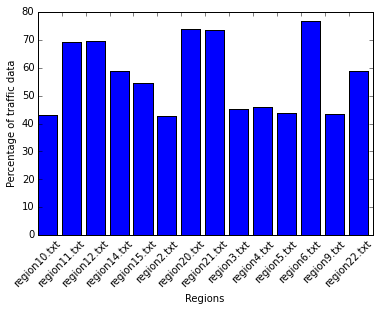

In [439]:
file_idx = [i for i in range(len(files))]
plt.bar(file_idx,percent)
plt.xticks(file_idx, files,rotation=45)
plt.xlabel('Regions')
plt.ylabel('Percentage of traffic data')
plt.show()

**Testing for labeled data**

In [458]:
def labeled_data_accuracy(filename,vec):
    '''
    Calculate the accuracy for labeled data
    params....
        filename....file name
        vec.........vec object of CountVectorizer
    '''
    tweets = get_file_data(filename)
    X_test = vec.transform(tweets)
    y_test = get_true_labels(filename)
    print('X_test represents %d documents with %d features' % (X_test.shape[0], X_test.shape[1]))
    print('y_test has %d traffic related and %d non traffic labels' % (len(np.where(y_test==1)[0]),
                                                              len(np.where(y_test==0)[0])))

    accuracy = accuracy_score(y_test, clf.predict(X_test))
    return accuracy
print('testing accuracy for region22.txt=%.4g' % labeled_data_accuracy('region22.txt',vec))

X_test represents 202 documents with 890 features
y_test has 104 traffic related and 98 non traffic labels
testing accuracy for region22.txt=0.9257


In [454]:
def verify_predictions(filenames):
    '''
    Verify predictions by comparing the percent of traffic data using true labels vs. the predicted labels.
    param.....
        filenames......list of filenames
    '''
    for filename in filenames:
        prediction=make_predictions(filename,vec)
        predicted_percent = get_traffic_data_percentage(prediction)
        actual_percent = get_traffic_data_percentage(get_true_labels(filename))
        print ('%s file predicted %.2f%% of traffic data where as actual ratio is %.2f%%'%(filename,predicted_percent,actual_percent))
verify_predictions(['region22.txt','region8.txt'])

region22.txt file predicted 58.91% of traffic data where as actual ratio is 51.49%
region8.txt file predicted 53.66% of traffic data where as actual ratio is 47.97%


#Experiment

**1. Removing retweets**

Here we will remove the retweets from our Training data(region1.txt) 
and train the classifier again then check the results.

In [477]:
#create a list of tweets and labels for region1 without the retweets
region1_filter_tweets = [t for t in region1_tweets if not t.startswith('RT')]
reg1_labels = np.array([label for i,label in enumerate(get_true_labels('region1.txt')) 
                        if not region1_tweets[i].startswith('RT')])

In [480]:
#calculating the accuracy after removing retweets
print('accuracy after removing Re-tweets: %.4g' % do_expt(region1_filter_tweets, reg1_labels))

accuracy after removing Re-tweets: 0.8407


**Conclusion:** We see that removing the retweets decreases the accuracy of the classifier.

**2. Reducing feature size**

Here we will reduce the number of features of the classifier by traning the classifier 
with less number of tweets compared to the previous.

Using region22.txt labeled data which contains 202 tweets.

In [489]:
#Get all tweets and labels for region22.txt
reg22_tweets = get_file_data('region22.txt')
reg22_labels = get_true_labels('region22.txt')
print 'region22.txt contains %d tweets' % (len(reg22_tweets))


region22.txt contains 202 tweets


In [494]:
#Vectorize the training data with best options
X, vec22 = do_vectorize(reg22_tweets, tokenizer_fn=tokenize,
                      options=['lowercase', 'collapse_urls', 'collapse_mentions'],
                      binary=True, min_df=2)
clf = get_clf()
clf.fit(X, reg22_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0)

In [495]:
#calculating the accuracy
print('accuracy score for region22.txt : %.4g' % do_expt(reg22_tweets, reg22_labels))

accuracy score for region22.txt : 0.7974


In [502]:
#now we calculate the accuracy of labeled file region1.txt using the classifier we created above
acc = labeled_data_accuracy('region1.txt',vec22)
print 'accuracy of region1.txt = %.4g' %acc

X_test represents 978 documents with 336 features
y_test has 438 traffic related and 540 non traffic labels
accuracy of region1.txt = 0.6125


**Note: ** It can be observed that when number of features are less, the accuracy score for larger data reduces

**3. Error Analysis**

In [506]:
#Reset the classifier to previous settings.
X, vec = do_vectorize(region1_tweets, tokenizer_fn=tokenize,
                      options=['lowercase', 'collapse_urls', 'collapse_mentions'],
                      binary=True, min_df=2)
clf = get_clf()
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0)

In [509]:
def get_top_errors(X_test, y_test, tweets, clf, n=10):
    """
    Use clf to predict the labels of the testing data in X_test. 
    We want to find incorrectly predicted documents. Furthermore, we want to look at those 
    where the probability of the incorrect label, according to the classifier, is highest.
    Params:
        X_test......the testing matrix
        y_test......the true labels testing tweets
        tweets......the list of text of tweets in file
        clf.........a trained LogisticRegression object
        n...........the number of errors to return
    Returns:
        A list of n dicts containing the following key/value pairs:
           index: the index of this document (in the filenames array)
           probas: a numpy array containing the probability of class 0 and 1
           truth: the true label
           predicted: the predicted label
           tweet: text of tweet
    """
    error_list = []
    err_dict = {}
    incorrect_labels = {}
    predicted = clf.predict(X_test)
    P = clf.predict_proba(X_test)
    
    for index in range(X_test.shape[0]):
        if(predicted[index] != y_test[index]):
            incorrect_labels[index] = P[index,predicted[index]]
            
    incorrect_labels = sorted(incorrect_labels.items(), key=lambda x:x[1],reverse=True) 

    for label in incorrect_labels:
        index = label[0]
        err_dict['tweet'] = (tweets[index])
        err_dict['index'] = index
        err_dict['predicted'] = predicted[index]
        err_dict['probas'] = P[index]
        err_dict['truth'] = y_test[index]
        error_list.append(err_dict)
        err_dict = {} 
    
    return error_list[:n]


errors = get_top_errors(vec.transform(reg22_tweets), reg22_labels, reg22_tweets, clf)
errors

[{'index': 44,
  'predicted': 1,
  'probas': array([ 0.00945491,  0.99054509]),
  'truth': 0,
  'tweet': u'@PaulWJR @MitchAlbom How come I no longer get show podcasts through iTunes? They make sitting in Chicago traffic much more enjoyable!!'},
 {'index': 52,
  'predicted': 1,
  'probas': array([ 0.01417983,  0.98582017]),
  'truth': 0,
  'tweet': u"Looks like I'll be driving 700 miles through a winter storm tomorrow. So that'll be fun. I always love Chicago traffic with a snowstorm."},
 {'index': 119,
  'predicted': 1,
  'probas': array([ 0.01608411,  0.98391589]),
  'truth': 0,
  'tweet': u"I'm glad Chicago Police are ghosts when it comes to writing tickets for blocking traffic.\n\nBut don't let them see you overstay parking!"},
 {'index': 83,
  'predicted': 1,
  'probas': array([ 0.03854697,  0.96145303]),
  'truth': 0,
  'tweet': u'That Chicago traffic was no joke though!'},
 {'index': 43,
  'predicted': 1,
  'probas': array([ 0.07270909,  0.92729091]),
  'truth': 0,
  'tweet': u'@

**4. Testing robustness of the classifier**

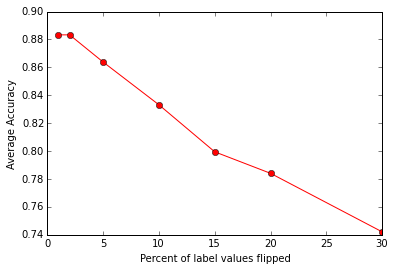

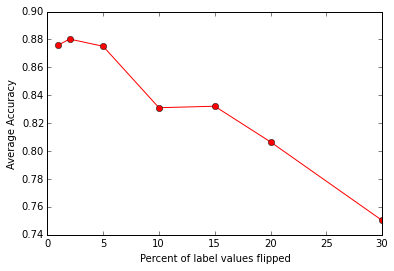

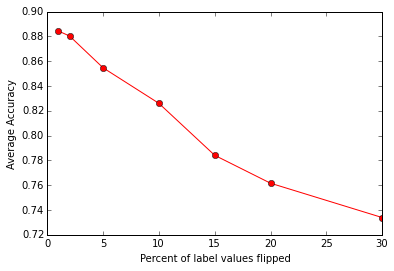

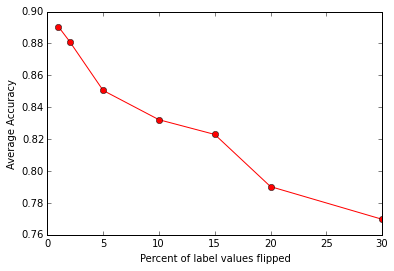

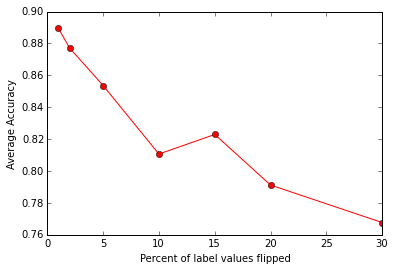

[[0.88331763474620628,
  0.88332810047095767,
  0.86384615384615382,
  0.8331868131868132,
  0.79948194662480376,
  0.7840711669283098,
  0.7421297749869179],
 [0.87616431187859756,
  0.88028780743066459,
  0.87514390371533213,
  0.8311041339612768,
  0.83217163788592363,
  0.80657770800627948,
  0.75030873888016747],
 [0.88434327577184724,
  0.88026164311878596,
  0.85465201465201468,
  0.82600209314495032,
  0.78409733124018843,
  0.76160125588697025,
  0.73392987964416534],
 [0.89048665620094192,
  0.88124542124542116,
  0.85054945054945053,
  0.83218733647305076,
  0.82294610151753012,
  0.79023024594453162,
  0.76972789115646267],
 [0.88947148090005235,
  0.87713239141810573,
  0.85364207221350075,
  0.81064887493458926,
  0.82293563579277862,
  0.79122448979591842,
  0.76769230769230767]]

In [547]:
def calc_robustness(tweets,y):
    '''
    This method calculates the robustness of the classifier.
    In this method we change small percentage of y label. eg. change 1 to 0 or 0 to 1.
    Random function selects the number of labels to be changed according to the percent value.
    eg. 10 percent of 700 labels has to be changed, then the random function chooses
    70 labels and flip its value.
    params....
        tweets......list of text of tweets
        y...........true label
    returns...
        list of average accuracies calculated for different percent of labels.
    '''
    change_label = [1,2,5,10,15,20,30]
    avg_acc = []
    for percent in change_label:
        y_copy = y.copy()
        rand_idx = random.sample(range(len(y_copy)),(len(y_copy)*percent/100))
        for idx in rand_idx:
            if y_copy[idx]==0:
                y_copy[idx]=1 
            if y_copy[idx]==1:
                y_copy[idx]=0

        avg_acc.append(do_expt(tweets,y_copy))
    
    plt.plot(change_label,avg_acc,'ro-')
    plt.xlabel('Percent of label values flipped')
    plt.ylabel('Average Accuracy')
    plt.show()
    return avg_acc
#run the cal_robustness() method 5 times to get 5 different accuracies.
acc=[]
for i in range(5):
    acc.append(calc_robustness(region1_tweets,y))
acc

In [557]:
#Computing standard deviation for different iteration of percent values
numpy_acc = np.array(acc)
np.std(numpy_acc,axis=1)

array([ 0.05006212,  0.04367757,  0.0548806 ,  0.04117709,  0.04162134])

**Conclusion: **From above we can see that the accuracy of the classifier 
decreases steeply after more than 2-5% of noise is induced in the labels